In [26]:
def calculate_eye_center(eye_landmarks):
    # Calculate the center of the eye based on the landmarks
    outer_corner_x, outer_corner_y = eye_landmarks[0]  # Landmark 36
    inner_corner_x, inner_corner_y = eye_landmarks[3]  # Landmark 39

    eye_center_x = (outer_corner_x + inner_corner_x) // 2
    eye_center_y = (outer_corner_y + inner_corner_y) // 2

    upper_eyelid_y = min(eye_landmarks[1][1], eye_landmarks[2][1])  # Landmarks 37 and 38
    lower_eyelid_y = max(eye_landmarks[4][1], eye_landmarks[5][1])  # Landmarks 40 and 41

    eye_center_y =  (upper_eyelid_y + lower_eyelid_y) // 2

    return eye_center_x, eye_center_y
def is_pupil_centered(eye_center, eyeball_center, threshold_distance):
    # Calculate the distance between the eye center and eyeball center
    distance = math.sqrt((eyeball_center[0] - eye_center[0])**2 + (eyeball_center[1] - eye_center[1])**2)
    #print(distance)
    # Check if the distance is less than the threshold value
    if distance < threshold_distance:
        return True
    else:
        return False

    
def detect_eyeball_centers(image_path):
    # Load pre-trained face detector and facial landmark predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

    # Read the input image
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = detector(gray_image)

    if len(faces) == 0:
        print("No face detected in the image.")
        return None, None

    # Get the facial landmarks for the first face detected
    face_landmarks = predictor(gray_image, faces[0])
    
    # Extract the left and right eye landmarks
    left_eye_landmarks = []
    right_eye_landmarks = []
    for i in range(36, 42):
        left_eye_landmarks.append((face_landmarks.part(i).x, face_landmarks.part(i).y))
    for i in range(42, 48):
        right_eye_landmarks.append((face_landmarks.part(i).x, face_landmarks.part(i).y))

    # Calculate the bounding boxes for the left and right eyes
    left_eye_x, left_eye_y, left_eye_w, left_eye_h = cv2.boundingRect(np.array(left_eye_landmarks))
    right_eye_x, right_eye_y, right_eye_w, right_eye_h = cv2.boundingRect(np.array(right_eye_landmarks))

    # Crop the eye regions
    left_eye_region = gray_image[left_eye_y:left_eye_y + left_eye_h, left_eye_x:left_eye_x + left_eye_w]
    right_eye_region = gray_image[right_eye_y:right_eye_y + right_eye_h, right_eye_x:right_eye_x + right_eye_w]

    # Apply Gaussian blur to reduce noise
    left_blurred_image = cv2.GaussianBlur(left_eye_region, (5, 5), 0)
    right_blurred_image = cv2.GaussianBlur(right_eye_region, (5, 5), 0)

    # Use adaptive thresholding to segment the eye regions
    _, left_thresholded_image = cv2.threshold(left_blurred_image, 50, 255, cv2.THRESH_BINARY_INV)
    _, right_thresholded_image = cv2.threshold(right_blurred_image, 50, 255, cv2.THRESH_BINARY_INV)

    # Find contours in the thresholded images
    left_contours, _ = cv2.findContours(left_thresholded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    right_contours, _ = cv2.findContours(right_thresholded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contours corresponding to the left and right eyeballs based on their size and shape
    left_eyeball_contour = None
    right_eyeball_contour = None
    left_max_area = 0
    right_max_area = 0

    for contour in left_contours:
        area = cv2.contourArea(contour)
        if area > left_max_area:
            left_max_area = area
            left_eyeball_contour = contour

    for contour in right_contours:
        area = cv2.contourArea(contour)
        if area > right_max_area:
            right_max_area = area
            right_eyeball_contour = contour

    if left_eyeball_contour is None or right_eyeball_contour is None:
        print("One or both eyeballs not detected.")

    # Calculate the moments of the contours to find their centroids
    left_moments = cv2.moments(left_eyeball_contour)
    right_moments = cv2.moments(right_eyeball_contour)
    left_eyeball_center_x = int(left_moments["m10"] / left_moments["m00"])
    left_eyeball_center_y = int(left_moments["m01"] / left_moments["m00"])
    right_eyeball_center_x = int(right_moments["m10"] / right_moments["m00"])
    right_eyeball_center_y = int(right_moments["m01"] / right_moments["m00"])

    # Draw the contours and centers on the image for visualization (optional)
    #cv2.drawContours(image, [left_eyeball_contour], -1, (0, 255, 0), 2)
    #cv2.drawContours(image, [right_eyeball_contour], -1, (0, 255, 0), 2)
    cv2.circle(image, (left_eye_x + left_eyeball_center_x, left_eye_y + left_eyeball_center_y), 2, (0, 255, 0), -1)
    cv2.circle(image, (right_eye_x + right_eyeball_center_x, right_eye_y + right_eyeball_center_y), 2, (0, 255, 0), -1)

    #Left eyeball centre
    left_eyeball_center = (left_eye_x + left_eyeball_center_x, left_eye_y + left_eyeball_center_y)
    right_eyeball_center = (right_eye_x + right_eyeball_center_x, right_eye_y + right_eyeball_center_y)
    
    
    # Calculate the center of the left and right eye
    left_eye_center_x, left_eye_center_y = calculate_eye_center(left_eye_landmarks)
    right_eye_center_x, right_eye_center_y = calculate_eye_center(right_eye_landmarks)
    
    left_eye_center= (left_eye_center_x, left_eye_center_y)
    right_eye_center= (right_eye_center_x, right_eye_center_y)
    
    cv2.circle(image, (left_eye_x + left_eye_center_x, left_eye_y + left_eye_center_y), 2, (0, 0, 255), -1)
    cv2.circle(image, (right_eye_x + right_eye_center_x, right_eye_y + right_eye_center_y), 2, (0, 0, 255), -1)
    
#     print("Left eye center:", left_eye_center)
#     print("Left eyeball center:", left_eyeball_center)
    
#     print("Right eye center:", right_eye_center)
#     print("right eyeball center:", right_eyeball_center)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(20,10))
    plt.imshow(img_rgb)
    plt.axis('off')
    
    return left_eyeball_center, right_eyeball_center, left_eye_center, right_eye_center

SyntaxError: 'break' outside loop (1043671589.py, line 94)

In [8]:
def facecheck(image_path):
    img = cv2.imread(image_path)
    face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face = face_classifier.detectMultiScale(gray, 1.3, 5)
    if (len(face)==0):
        print("no forward facing face detected")
        #return False
    else:
        for (x, y, w, h) in face:
            print("face detected")
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 4) 
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.figure(figsize=(20,10))
            plt.imshow(img_rgb)
            plt.axis('off')
            #return True
        
     
    

In [9]:
def smilecheck(image_path):
    img = cv2.imread(image_path)
    face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face = face_classifier.detectMultiScale(gray, 1.3, 5)
    smile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')
    
    for (x, y, w, h) in face:
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 4)

        roi_gray = gray[y:y+w, x:x+w]
        roi_color = img[y:y+h, x:x+w]

        smile = smile_cascade.detectMultiScale(roi_gray,1.8, 20, minSize=(50,50))
        
        if (len(smile)==0):
            print("person is not smiling")
            #return False
        else:
            for (mx, my, mw, mh) in smile:
                print("person is smiling")
                cv2.rectangle(roi_color, (mx, my), (mx+mw, my+mh), (255, 0, 0), 5) 
                
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.figure(figsize=(20,10))
                plt.imshow(img_rgb)
                plt.axis('off')
                #return True
        
    
    

In [10]:
def gazecheck(image_path):
    left_eyeball_center, right_eyeball_center, left_eye_center, right_eye_center = detect_eyeball_centers(image_path)
    if ( (is_pupil_centered(left_eye_center,left_eyeball_center,5 ) ) and (is_pupil_centered(right_eye_center,right_eyeball_center,5 ) ) ):
        print("Eyes are facing camera")
        #return True
    
    else:
        print("Eyes not facing camera")
        #return False

In [11]:
def mouthcheck(image_path):
    hog_face_detector = dlib.get_frontal_face_detector()
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    shape_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
    faces = hog_face_detector(gray)

# Iterate over detected faces and get facial landmarks for each face
    for face in faces:
        face_landmarks = shape_predictor(gray, face)
        diff1= face_landmarks.part(67).y - face_landmarks.part(61).y 
        diff2= face_landmarks.part(66).y - face_landmarks.part(62).y 
        diff3= face_landmarks.part(65).y - face_landmarks.part(63).y 
        #print(diff1,diff2,diff3)
        if ( (diff1<4) and (diff1<4) and (diff1<4) ):
            print("mouth is closed")
        else:
            print("mouth is open")

In [14]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import math

#SCROLL TO SEE ALL OUTPUTS

def main(image_path):
    facecheck(image_path)
    smilecheck(image_path)
    gazecheck(image_path)
    mouthcheck(image_path)


    

face detected
person is smiling
Eyes are facing camera
mouth is closed


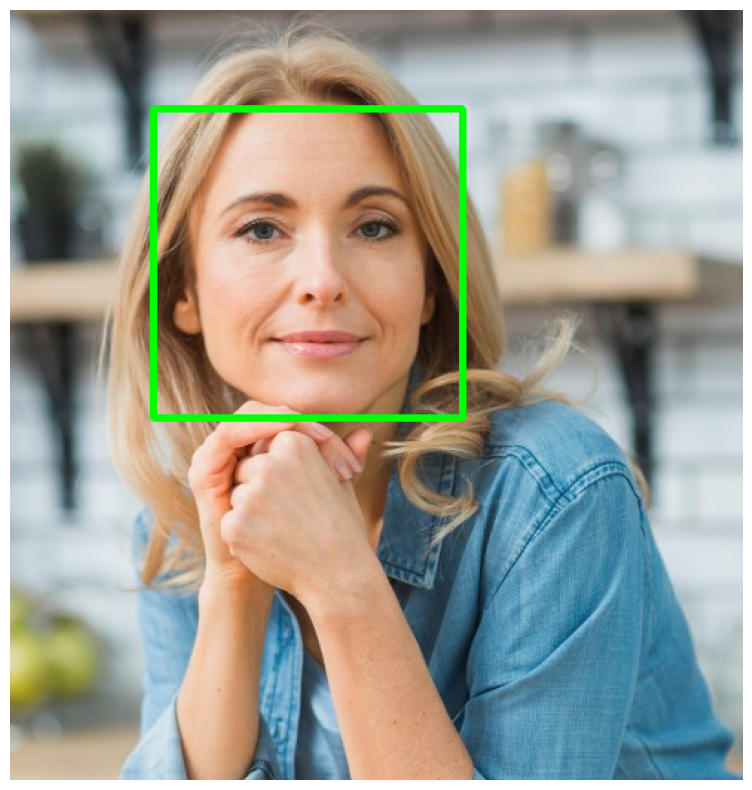

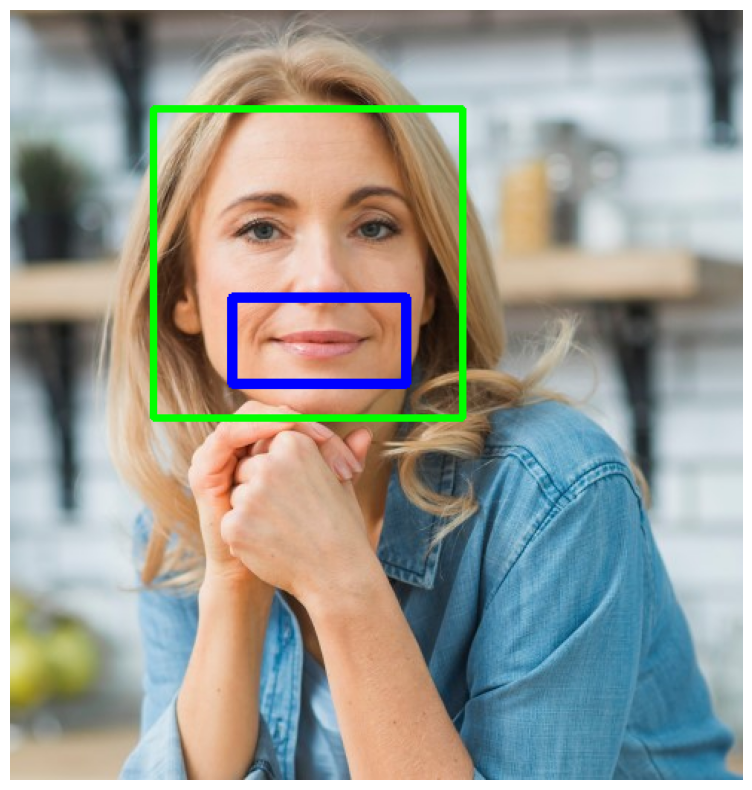

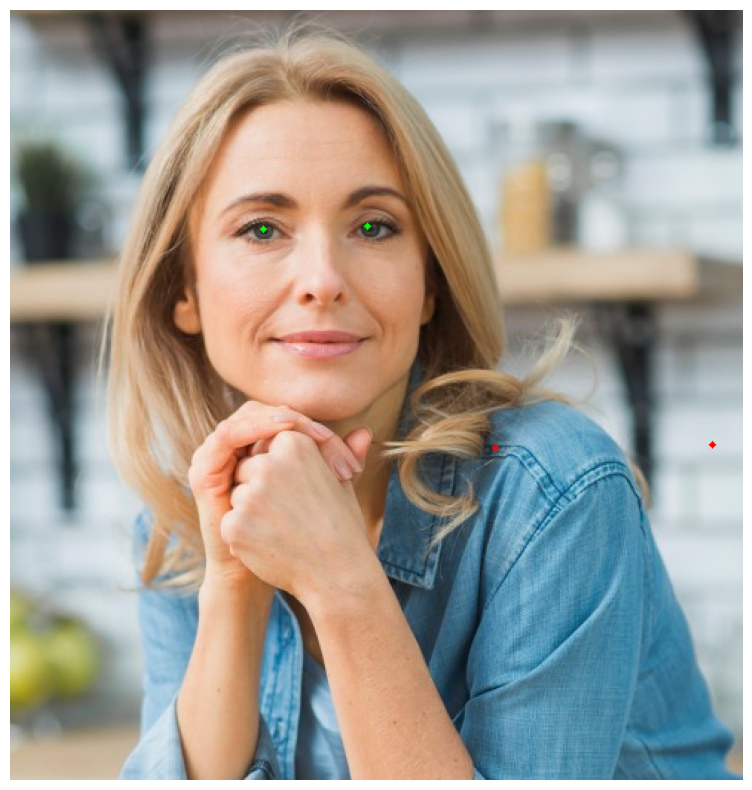

In [15]:
main(image_path='img4.jpg')

face detected
person is not smiling
Eyes not facing camera
mouth is closed


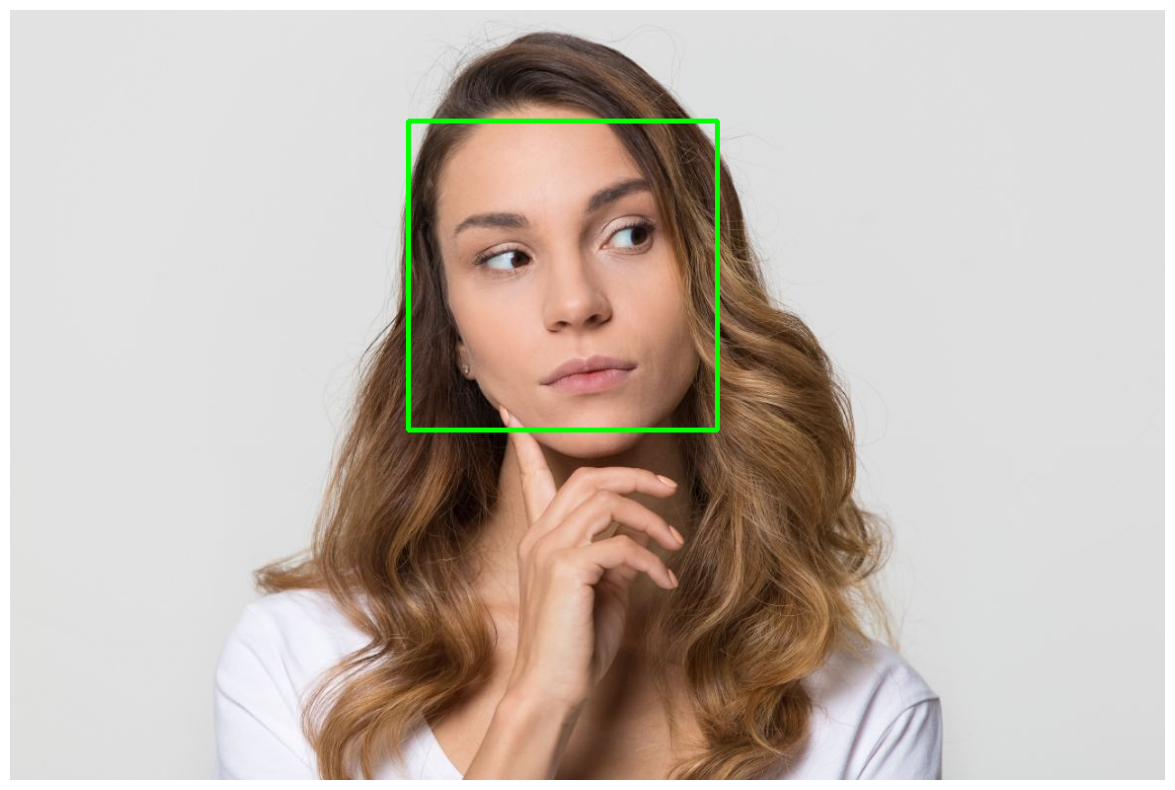

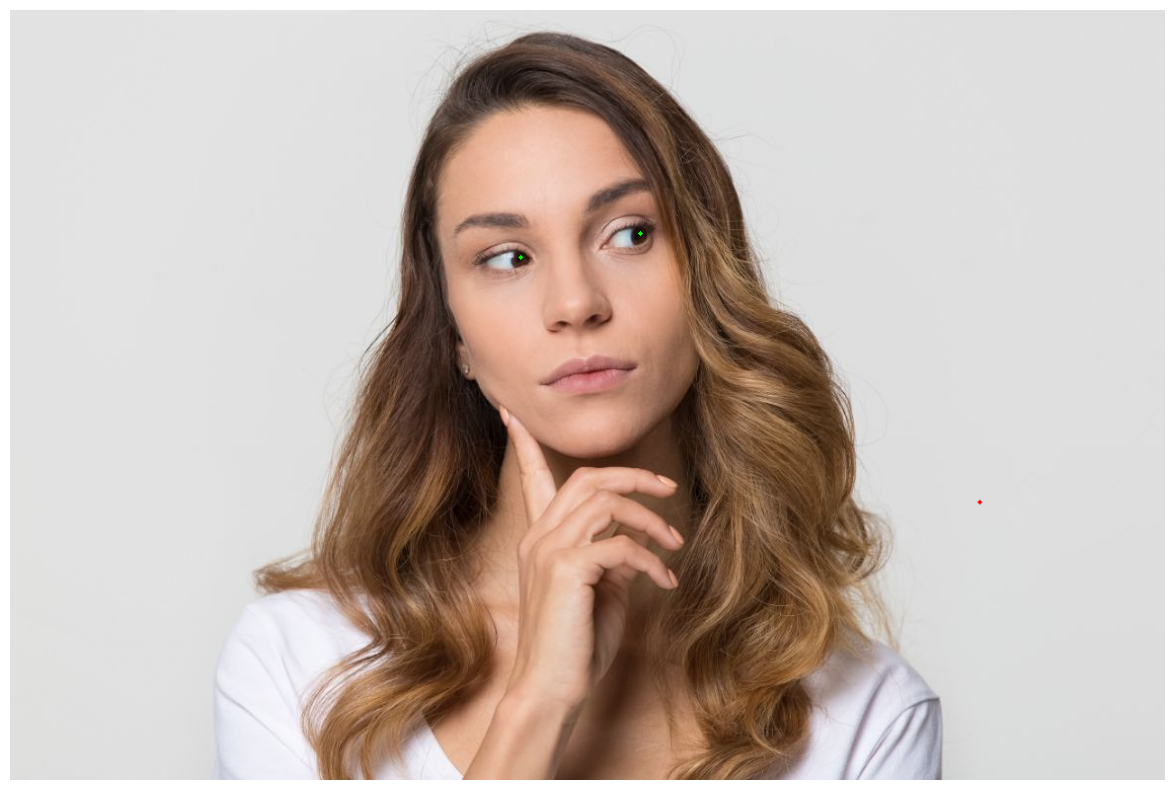

In [16]:
main(image_path='sideLook.jpg')

face detected
person is not smiling
Eyes not facing camera
mouth is closed


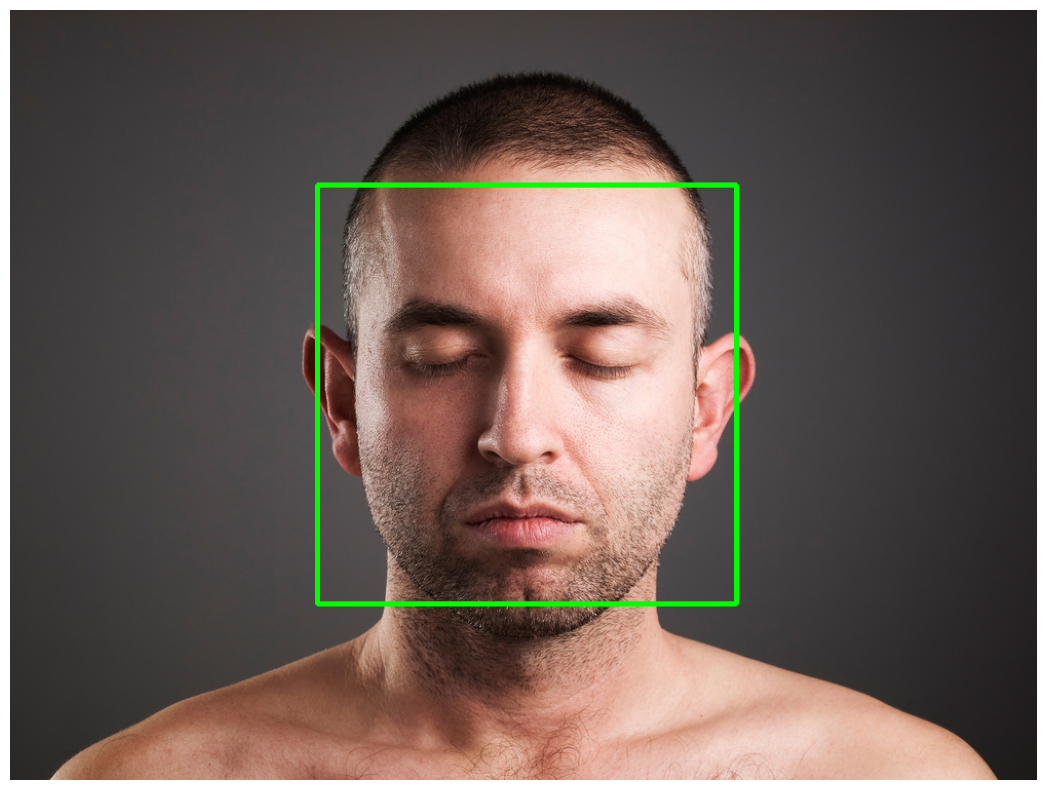

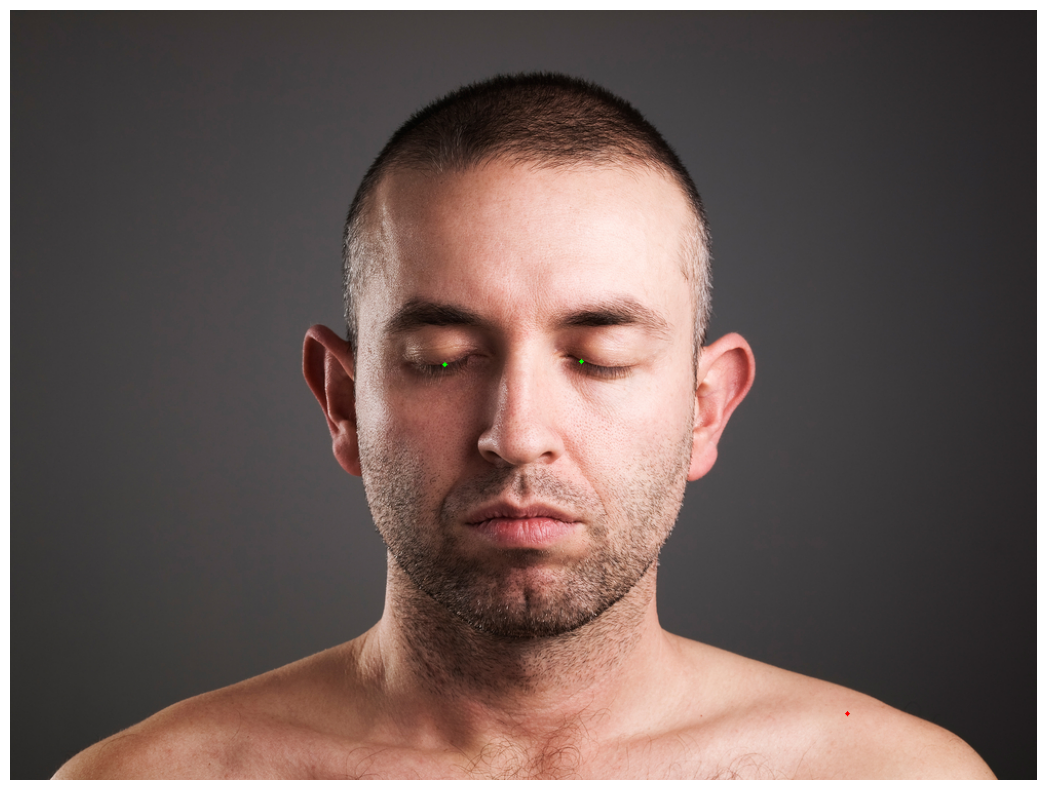

In [27]:
main(image_path='img9.jpg')

face detected
person is smiling
person is smiling
Eyes not facing camera
mouth is open


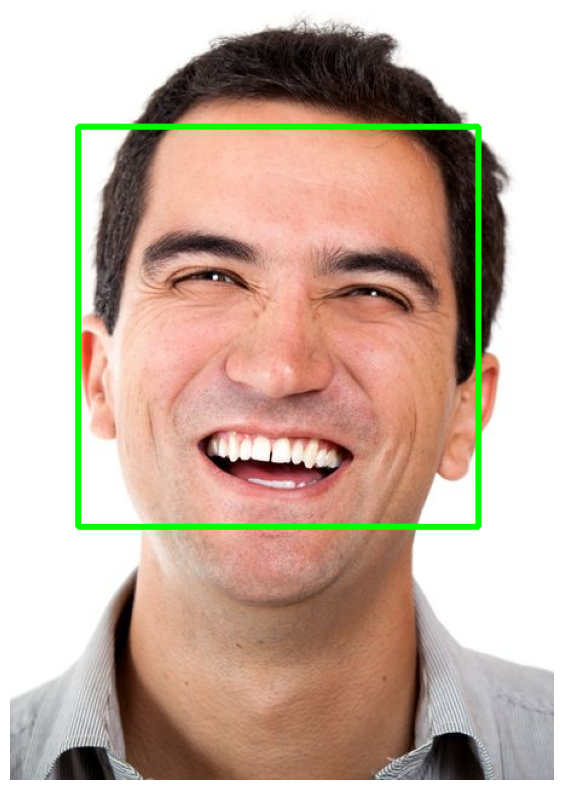

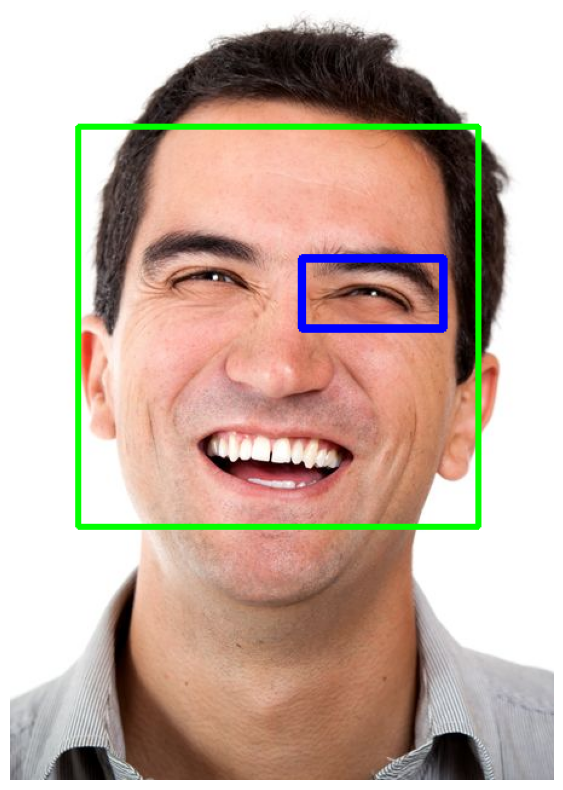

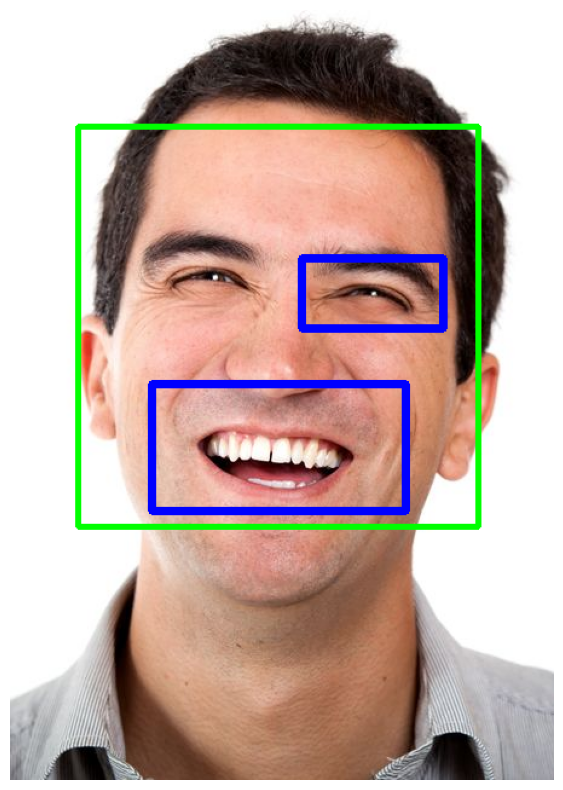

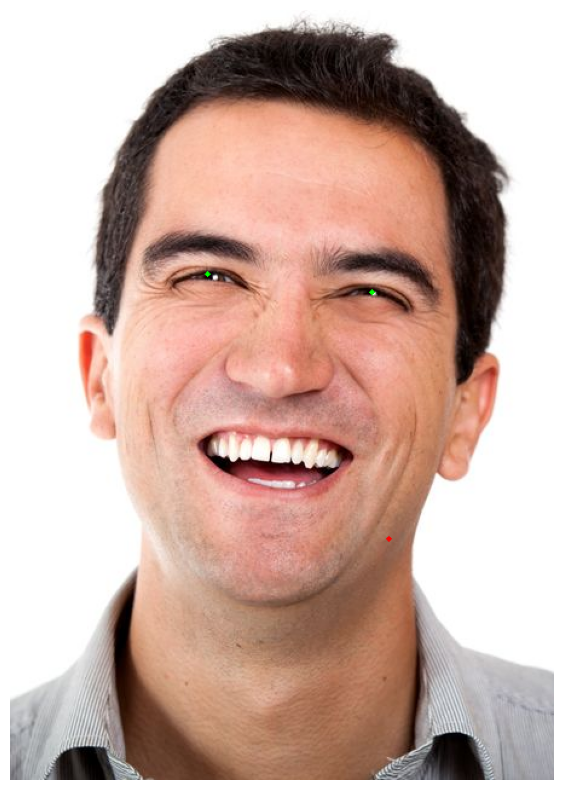

In [19]:
main(image_path='smile.jpg')